# Projekt PRIAD

## Rozpoznawanie autora utworu literackiego na podstawie treści utworu z wykorzystaniem worka słów.

### Stanisław Maliński, Jan Stachurski

Importy

In [1]:
import os
import pandas as pd
import numpy as np
from math import log

In [2]:
import warnings
warnings.filterwarnings("ignore")

Wczytywanie danych

In [3]:
data_path = "./data/"
file_list = os.listdir(data_path)
func = lambda  a : a.replace(".txt", "").split("-")
count_size = lambda a : os.stat(a).st_size
data = [[func(title)[0], func(title)[1], data_path + title, count_size(data_path + title)] for title in file_list]
files = pd.DataFrame(data, columns=['Author', 'Name of The work', 'FilePath', 'FileSize'])

Przedstawiam zestaw uczący. Mamy tutaj pozycję kilku Polskich autorów.

In [4]:
print(files.drop(columns=['Name of The work', 'FilePath']).groupby('Author').sum())

                   FileSize
Author                     
AdamMickiewicz       886513
HenrykSienkiewicz   9135412
Juliusz Słowacki     798784


Wczytanie stop-słów:

In [5]:
def get_stop_words():
    delimeters = ["\\n", "'"]
    stop_words = []
    with open("./stopyPL.txt", encoding="utf8") as f:
        for line in f:
            word = repr(line)
            for c in delimeters:
                word = word.replace(c, "")
            stop_words.append(word)
    return stop_words

Projekt ten używa worka słów, który to przechowuje informacje na temat częstości występowania słów w danym dokumencie. Definiujemy tu dwie funckje jedna do standaryzacji słów tzn. usunięcia ewentualnych znaków graficznych takich jak kropka czy przecinek oraz ustawienie wielkości liter na małe aby słowa "Który" oraz "który" były zliczane jako to same słowo.
Druga funkcja służy do budowania worka słów. Zlicza najpierw pojedyńcze przypadki wystąpień, a następnie zlicza częstość wystąpień danego słowa.

In [6]:
special_char = [".", ",", "-", "?", "(", ")", "!", "\\", "\"", ":", ";", "*"]
def normalize_text(word):
    for char in special_char:
        word = word.replace(char, "")
    word = word.lower()
    return word

def get_text(FileName):
    out = ""
    n = 0
    with open(FileName, "r", encoding="utf8") as f:
        for line in f:
            out += line
            n += 1
        f.close()
    return (n, out)
        
# 0 - generete bag with all words, 1 - bag without stopwords, 2 - bag with only stopwords
stop_word = get_stop_words()
def generate_word_bag(text, mode=0):
    word_bag = {}
    words_in_bag = 0
    f = text.split("\n")
    set_w = set()
    for line in f:
        words = line.split()
        for word in words:
            if word != '':
                if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
                    words_in_bag += 1
                    if word in set_w:
                        word_bag[word]['Count'] += 1
                    else:
                        word_bag[word] = {'Count':1, 'Frequent':1, 'Is stop word': word in stop_word}
                        set_w.add(word)

    for word in word_bag.keys():
        word_bag[word]['Frequent'] = word_bag[word]['Count'] / words_in_bag
    return (word_bag, set_w)                                                        

In [7]:
def get_random_fragment(FileName, n, mode=0):
    stop_word = get_stop_words()
    word_bag = {}
    words_in_bag = 0
    with open(FileName, "r", encoding="utf8") as f:
        for line in f:
            words = line.split()
            words = [normalize_word(word) for word in words]
            for word in words:
                if word != '':
                    if (mode==0) or (mode==1 and not word in stop_word) or (mode==2 and word in stop_word):
                        words_in_bag += 1
                        if word in word_bag.keys():
                            word_bag[word]['Count'] += 1
                        else:
                            word_bag[word] = {'Count':1, 'Frequent':1, 'Is stop word': word in stop_word}
                                    
        f.close()
    for word in word_bag.keys():
        word_bag[word]['Frequent'] = word_bag[word]['Count'] / words_in_bag
    return word_bag          

In [8]:
file = files['FilePath'][0]
dictionary = generate_word_bag(get_text(file)[1])[0]
slowa = dictionary.keys()
slowo = list(slowa)[2]

print("W pliku: \"{}\" Słowo: \"{}\" występowało z częstością: {:.2e}".format(file, slowo, dictionary[slowo]['Frequent']))

W pliku: "./data/AdamMickiewicz-DziadyII.txt" Słowo: "Dziady," występowało z częstością: 2.89e-04


In [9]:
def head(dictionary, start=0, end=None, step=1, fname=None):
    words = list(dictionary.keys())
    if end is None:
        end = min(5, len(words))
    if fname is not None:
        print("W pliku: \"{}\"".format(fname))
    for word in words[start:end:step]:
        print("Słowo: \"{}\" występowało z częstością: {:.2e}".format(word,dictionary[word]['Frequent']), sep="")

In [10]:
file = files["FilePath"][1]
dictionary = generate_word_bag(get_text(file)[1], 2)[0]
head(dictionary, end=10, fname=file)

W pliku: "./data/AdamMickiewicz-DziadyIII.txt"
Słowo: "za" występowało z częstością: 1.64e-02
Słowo: "ku" występowało z częstością: 3.09e-03
Słowo: "z" występowało z częstością: 4.84e-02
Słowo: "w" występowało z częstością: 7.43e-02
Słowo: "na" występowało z częstością: 4.67e-02
Słowo: "od" występowało z częstością: 6.37e-03
Słowo: "tak" występowało z częstością: 8.88e-03
Słowo: "i" występowało z częstością: 7.35e-02
Słowo: "się" występowało z częstością: 5.17e-02
Słowo: "nie" występowało z częstością: 5.54e-02


In [ ]:
def show_most_frequent(dic ,threshold=0):
    po_czestosci = dict(sorted(dic.items(), key=lambda x: int(x[1]['Count']), reverse = True))
    for index, word in enumerate(po_czestosci.keys()):
        if threshold == 0 and index < 10:
            print(word + " -> " + str(po_czestosci[word]['Count']))
        elif threshold == 0:
            break
        elif po_czestosci[word]['Count'] > threshold:
            print(word + " -> " + str(po_czestosci[word]['Count']))
        else:
            break
            
        
show_most_frequent(dictionary, 80)

Mamy już mały warsztat narzędzi do analizy utworów. Stworzymy teraz parę funckji, które pozwolą nam zgrabnie manipulować macierzą danych. 
merge_dics_to_df - łączy worki słów w ramkę danych, którą później wykorzystamy do nauki klasyfikatora.
tf_idf - analiza TF_IDF.

In [12]:
def merge_dics_to_df(dics_and_sets, labels=None, transform=lambda x:x):
    tab = []
    word_found = set()
    index = []
    for dic, _ in dics_and_sets:
        words = list(dic.keys())
        for word in words:
            if not word in word_found:
                word_found.add(word)
                index.append(word)
                rec = []
                for dictionary, set_w in dics_and_sets:
                    if word in set_w:
                        rec.append(transform(dictionary[word]))
                        del dictionary[word]
                        set_w.remove(word)
                    else:
                        rec.append(0)
                tab.append(rec)
            
    
    df = pd.DataFrame(tab, columns=labels, index=index)

        
    return df.T
    
df = merge_dics_to_df([({'1': 1, '2': 2}, set(['1', '2'])), 
                        ({'3': 3, '2': 2}, set(['2', '3'])),
                        ({'3': 3, '2': 2, '4': 4, '7':7}, set(['3', '2', '4', '7']))], 
                       labels=["Pierwszy słownik", "Drugi słownik", "Trzeci słownik"])
print(df)
df['label'] = ["pierwszy", "drugi", "trzeci"]

2
1
2
                  1  2  3  4  7
Pierwszy słownik  1  2  0  0  0
Drugi słownik     0  2  3  0  0
Trzeci słownik    0  2  3  4  7


In [13]:
def tfidf(data):
    df = data.copy()
    df = df.drop(columns=['label'])
    nwords = df.shape[1]
    nbooks = df.shape[0]
    tf = np.empty((nbooks, nwords))
    sm = df.sum(axis=1)
    for i in range(nbooks):
        tf[i,:] = np.array(df.iloc[i,: ] / sm[i])
    inbooks = np.array((df > 0)*1).sum(axis=0)
    idf = [log(nbooks / val, 10) for val in inbooks]
    tfidf = pd.DataFrame((tf*np.array([idf,]*nbooks)*100), columns=df.columns)
    return tfidf
    
idf = tfidf(df)
print(idf)

           1    2          3          4          7
0  15.904042  0.0   0.000000   0.000000   0.000000
1   0.000000  0.0  10.565476   0.000000   0.000000
2   0.000000  0.0   3.301711  11.928031  20.874055


In [14]:
def drop_threshold(df, threshold):
    to_drop = []
    labels = df['label']
    df = df.drop(columns='label')
    for col in df.columns:
        if (df[col] < threshold).all():
            to_drop.append(col)
            
    return df.drop(columns=to_drop)

Teraz musimy stworzyć model, który będzie klasyfikował do jakiego autora należy dany utwór.

Wczytanie obliczenie słowników dla wszystkich utworów.

In [15]:
def load(files, mode=2):
    word_bags = []
    index = []
    labels = []

    for path, name, label in zip(files['FilePath'], files['Name of The work'], files['Author']):
        n, cont = get_text(path)
        cont = normalize_text(cont)
        word_bags.append(generate_word_bag(cont, mode=mode))
        index.append(name)
        labels.append(label)
        
    df = merge_dics_to_df(word_bags, index, lambda x:x['Count'])
    df['label'] = labels
        
    return df          

In [16]:
#df = load(files,mode=2)        
import cProfile
import re
cProfile.run('df = load(files, mode=2)')
df.head()

151
92
9
6
1
13
0
6
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
         163706 function calls (163652 primitive calls) in 8.795 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.009    0.009    0.020    0.020 147799849.py:1(merge_dics_to_df)
       26    0.030    0.001    0.281    0.011 24617762.py:2(normalize_text)
       26    6.647    0.256    6.835    0.263 24617762.py:20(generate_word_bag)
       26    1.599    0.062    1.643    0.063 24617762.py:8(get_text)
        1    0.015    0.015    8.795    8.795 3646335856.py:1(load)
     5911    0.002    0.000    0.002    0.000 3646335856.py:13(<lambda>)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(append)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
       33    0.000    0.000    0.000    0.000 <__array

,jest,to,między,w,wielu,i,na,czyli,ta,się,...,dużo,natomiast,jednakże,dokąd,poza,możliwe,toteż,aczkolwiek,nia,label
DziadyII,10,45,1,87,1,92,46,7,6,46,...,0,0,0,0,0,0,0,0,0,AdamMickiewicz
DziadyIII,65,179,9,441,6,584,267,2,15,318,...,0,0,0,0,0,0,0,0,0,AdamMickiewicz
DziadyIV,28,60,3,160,1,210,161,6,14,150,...,0,0,0,0,0,0,0,0,0,AdamMickiewicz
Grażyna,12,34,10,149,1,239,169,9,3,117,...,0,0,0,0,0,0,0,0,0,AdamMickiewicz
KonradWallendrod,22,53,12,325,6,436,212,3,4,216,...,0,0,0,0,0,0,0,0,0,AdamMickiewicz


Jak widzimy mamy już ramkę danych, w której każdym obiektem jest dzieło a wektorem atrybutów jest częstość wystąpień poszczególnych słów w każdym z dzieł. Dodaliśmy również atrybuty decyzyjny czyli nazwisko autora danego dzieła.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

Metoda get_learning_data dzieli naszą macierz danych na dane uczące oraz testowe w pewnej proporcji. Dzięki temu będziemy mogli zweryfikować jak dobry nasz model jest.

In [18]:
def get_learning_data(df, proporcja):
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}

In [19]:
def weryfikuj(model,dane,show=True):
    model.fit(dane["opis_ucz"], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"])
    wynik_test = model.predict(dane["opis_test"])

    learn_s = model.score(dane['opis_ucz'], dane['dec_ucz'])
    test_s = model.score(dane['opis_test'], dane['dec_test'])
    
    if show:
        print("\tWynik dla danych uczących: ", end="")
        print(learn_s)
        print("\tWynik dla danych testowych: ", end="")
        print(test_s)
    
    return learn_s, test_s

In [29]:
models = (("NS", KNeighborsClassifier(n_neighbors=1)), 
          ("KNS5", KNeighborsClassifier(n_neighbors=5)),
          ("KNS10", KNeighborsClassifier(n_neighbors=10)),
          ("BK", GaussianNB()),
          ("DT5", tree.DecisionTreeClassifier(max_depth=5)),
          ("DT10", tree.DecisionTreeClassifier(max_depth=10)))


Przeprowadzimy teraz klasyfikacje na danych testowych w trzech wariantach:
* Worek słów składa się wyłącznie z stop słów   
* Worek słów składa się ze słów, które nie są stop słowami   
* Worek słów będzie składał się ze wszystkich słów   

Do wykonania tego zadania posłuży nam metoda:

In [82]:
def test_classifier(df, tries=100):
    res = {}
    progress = len(models)*tries
    l_space = max([len(str(model)) for model in models])
    for index, name_mod in enumerate(models):
        name, mod = name_mod
        if mod is None:
            break
        sum_t = 0
        sum_l = 0
        ofs = str(l_space - len(str(mod)) - 10)
        line = "Ukończono w {pr:.2f}% - Sprawdzono model \"{m}\"{o:<" + ofs + "} razy {t}##"
        for i in range(1, tries + 1):
            data = get_learning_data(df, 0.2)
            d_l, d_t= weryfikuj(mod, data, show=False)
            sum_l += d_l
            sum_t += d_t
            print(line.format(pr=(index*tries + i)*100/progress,
                              m=str(mod), 
                              o="",
                              t=i) , end='\r')
        res[name] = (sum_l/tries, sum_t/tries)
    respd = pd.DataFrame(res, index=["testowe", "uczące"])
    
    return respd.T

In [32]:
cProfile.run('data1 = load(files,mode=1)')
data2 = load(files, mode=2)
data3 = pd.concat([data1.copy(), data2.copy()], axis=1)

1321
6133
2173
2131
3026
13306
387
14069
404
9781
8017
9679
9818
6715
7321
4584
7873
4189
494
0
2779
1659
90
1628
735
576
         4518298 function calls (4518244 primitive calls) in 14.181 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.753    1.753    3.395    3.395 147799849.py:1(merge_dics_to_df)
       26    0.021    0.001    0.267    0.010 24617762.py:2(normalize_text)
       26    8.648    0.333    8.909    0.343 24617762.py:20(generate_word_bag)
       26    1.452    0.056    1.494    0.057 24617762.py:8(get_text)
        1    0.049    0.049   14.166   14.166 3646335856.py:1(load)
   310916    0.114    0.000    0.114    0.000 3646335856.py:13(<lambda>)
        2    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(append)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
        2    0.000    0.000    0.001    0.000 <__array_function__ internals>:

151
92
9
6
1
13
0
6
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1


In [84]:
print("Klasyfickaja bez stop słów")
datau1 = tfidf(data1)
respd1 = test_classifier(datau1, 5)
respd1.plot(kind='bar', rot = 45)

Klasyfickaja bez stop słów


KeyboardInterrupt: 

Klasyfickaja na stop słowach


<AxesSubplot:>

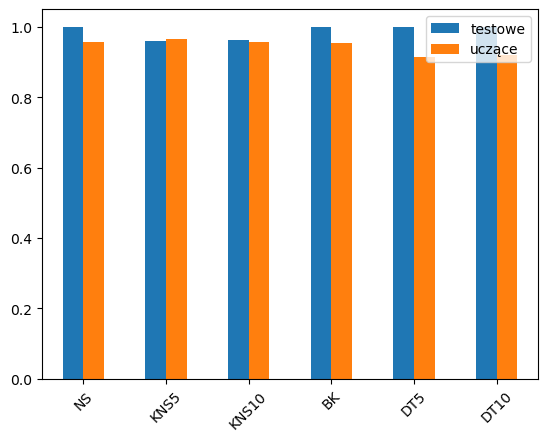

In [83]:
print("Klasyfickaja na stop słowach")
datau2 = tfidf(data2)
respd2 = test_classifier(datau2)
respd2.plot(kind='bar', rot = 45)

In [ ]:
print("Klasyfickaja na wszystkich słowach")
datau3 = tfidf(data3)
respd3 = test_classifier(datau3)
respd3.plot(kind='bar', rot = 45)

Jak widzimy modele z dość dużym prawdopodobieństwem są w stanie sklasyfikować autora do jego dzieła na podstawie samych stop słów.

In [ ]:
data1

In [ ]:
data1m = drop_threshold(data1, 5)
data1m